# CONVOLUTIONAL NEURAL NETWORKS IN TENSORFLOW

![Tensorflow](Tensorflow.png)

 ## Introduction

This tutorial will introduce you to convolutional neural networks. The primary role of any data science professional is to extract hidden patterns from data. While general machine learning techniques are sufficient for majority of the tasks,neural networks are particularly useful when the data is composed of images,speech or video. Convolutional neural network is a specific type of neural network which is primarily used for computer vision tasks (i.e image recognition).

Recently a company called iSono Health used convolutional neural networks to develop a cost efficient automated ultrasound imaging platform to help women detect breast cancer early. The person who built the deep learning model for iSono Health is a data scientist. In this [article](https://blog.insightdatascience.com/automating-breast-cancer-detection-with-deep-learning-d8b49da17950) he talks about how he used several data science techniques such as data preprocessing and preparation to build the final model.

Researchers at the University of Bonn are attempting to use convolutional neural networks in agricultural robots to monitor crop health so as to promote sustainable farming, thereby reducing the dependence on fertilizers, herbicides and pesticides. For further information please refer to this [article](https://www.kdnuggets.com/2017/11/real-world-deep-learning-neural-networks-smart-crops.html).

Convolutional neural network is the choice of tool for nearly all image related tasks and this tutorial will introduce you to the basics.

![Convolutional Neural Network](cnn.png)

## Tutorial Topics

In this tutorial a convolutional neural network is built using [tensorflow](https://www.tensorflow.org/). If you haven't come across tensorflow before please go through this link [Basics of tensorflow](https://medium.com/@curiousily/tensorflow-for-hackers-part-i-basics-2c46bc99c930) before you proceed.

The following topics are covered in this tutorial:
- [Installing tensorflow](#Installing-tensorflow)
- [Loading data and visualization](#Loading-data-and-visualization)
- [Creating layers of the network](#Creating-layers-of-the-network)
- [Setting up the images](#Setting-up-the-images)
- [Running the session](#Running-the-session)
- [Summary and References](#Summary-and-References)

## Installing tensorflow

Please run the following command in your jupyter notebook.

!pip install tensorflow==1.3.0

After you run the above command please make sure the following libraries work for you.

In [120]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Loading data and visualization

The dataset used in this tutorial is the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html). The dataset consists of 60000 32 x 32 color images in ten possible classes. 50000 images are use to train the model and 10000 images are used to test the model. There are five training batches and one test batch and each batch contains 10000 images. The training batches contain random images whereas the test batch contains exactly 1000 images from each posible class.

Once you download the dataset please save it in the same directory as this tutorial.

In [121]:
# Load the data and check if it has been loaded properly
Directory_name='cifar-10-batches-py/'
files_name=['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

The creators of the CIFAR-10 dataset provided the below function to extract the data.

In [122]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

We now create the various training batches and the test batch.There are five training batches and one test batch.

In [123]:
Batches_meta=unpickle(Directory_name + files_name[0])
Data_batch_1=unpickle(Directory_name + files_name[1])
Data_batch_2=unpickle(Directory_name + files_name[2])
Data_batch_3=unpickle(Directory_name + files_name[3])
Data_batch_4=unpickle(Directory_name + files_name[4])
Data_batch_5=unpickle(Directory_name + files_name[5])
Test_batch=unpickle(Directory_name + files_name[6])

In [124]:
# Keys of the various data batches and test batch
Data_batch_1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

data-10000 x 3072 numpy array. Each row stores a 32x32 image. The 3072 value is split as follows: first 1024 values correspond to the red channel,next 1024 values to green channel and last 1024 values to blue channel. 

labels-10000 numbers in the range 0-9. These represent the possible class values of the image.

In [125]:
# The various possible classes
Batches_meta

{b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_cases_per_batch': 10000,
 b'num_vis': 3072}

![Classes](pic.png)

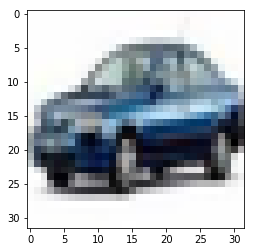

In [126]:
# Visualizing a single image
image=Data_batch_1[b'data']
image=image.reshape(10000,3,32,32).transpose(0,2,3,1)
plt.imshow(image[105],interpolation='nearest')

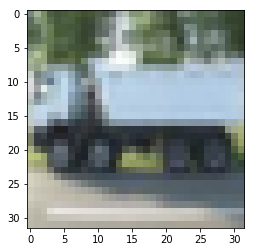

In [127]:
plt.imshow(image[369],interpolation='nearest')

## Creating layers of the network

Most of the Convolutional neural network architectures used in practice consists of three main layers: Convolutional layer,Max pooling layer and the Fully connected layer. Description of the layers in detail:

Input [32X32X3]- The input to the CNN is an image of height and width equal to 32 pixels and with three color channels (red,green,blue). 

Convolutional Layer  [32x32xnumber of filters]- each neuron will compute the dot product between their weights and a small region in the input. This layer is used to identify the various features in the input such as straight edges,curves,colors et cetera.

Relu [32x32xnumber of filters]- this layer will apply an activation function to each element ( max(0,element) thresholding at zero).The output is the same size as the input. Note there can be other activation functions, such as sigmoid(rarely used), hyperbolic tangent function (tanh) et cetera.

Pool [16x16xnumber of filters]- this operation will reduce the size along the height and width. In addition this operation controls the number of parameters, thereby controlling overfitting. There are several pooling operations that can be used such as max-pooling, average pooling, L2 norm pooling et cetera. In this tutorial I've used max pooling operation.

Fully Connected Layer [1x1x10]- this layer will compute the final scores of each class. Each neuron in this layer will be connected to all the neurons in the previous layer. The activation of this layer is calculated with a matrix multiplication and a bias value.


#### Hyperparameters

Stride- we use this hyperparameter to slide over the input. For example when the stride is two then we move the filter two pixels at a time.

Zero-padding - this hyperparameter is used to preserve information from the original input so that we can extract the low level features.

If you require additional clarity on some of the terminologies mentioned, please refer to this [paper](http://cs231n.github.io/convolutional-networks/)

In [128]:
# Helper Functions for the various layers

# Initialization of weights and bias
def weights(size):
    stddev_truncated_normal=0.1
    Weights=tf.truncated_normal(shape=size,stddev=stddev_truncated_normal)
    return tf.Variable(Weights)

def bias(size):
    value_bias=0.1
    Bias=tf.constant(value=value_bias,shape=size)
    return tf.Variable(Bias)

def conv2D(input_x,m):
    return tf.nn.conv2d(input_x,m,strides=[1,1,1,1],padding='SAME')

def max_pool(conv_output):
    stride_length=2
    return tf.nn.max_pool(conv_output,ksize=[1,stride_length,stride_length,1],strides=[1,2,2,1],padding='SAME')

def conv_layer(input_x,size):
    w=weights(size)
    b=bias([size[3]])
    conv_output=conv2D(input_x,w)+b
    return tf.nn.relu(conv_output)

def fully_connected_layer(input_layer,user_size):
    Shape=int(input_layer.get_shape()[1])
    w=weights([Shape,user_size])
    b=bias([user_size])
    matrix_multiplication=tf.matmul(input_layer,w)
    return  (matrix_multiplication + b)

In [129]:
# Place holders [None] since we assign the size of the batch later
x=tf.placeholder(tf.float32,shape=[None,32,32,3]) 
ytrue=tf.placeholder(tf.float32,shape=[None,10])

holdout_prob=tf.placeholder(tf.float32)

In [130]:
# Various Layers 2 convolutional layers 2 max pool layers and 1 fully connected layer
conv_layer1=conv_layer(x,[5,5,3,32])
max_pool1=max_pool(conv_layer1)

# Filter size can vary I've used 5X5 filter
conv_layer2=conv_layer(max_pool1,[5,5,32,64])
max_pool2=max_pool(conv_layer2)

# we have used 2 max pool layers so 32/2/2=8 
reshaped_layer=tf.reshape(max_pool2,[-1,8*8*64])
full_layer=tf.nn.relu(fully_connected_layer(reshaped_layer,1024))

random_dropout=tf.nn.dropout(full_layer,keep_prob=holdout_prob)
ypred=fully_connected_layer(random_dropout,10)

####  Dropout and Optimizer

Dropout - this is a technique to combat overfitting in neural networks. In this technique half the neurons are deactivated from a specific layer during training. In this tutorial I have used dropout only on the fully connected layer. When we are testing the model the dropout is deactivated.

Optimizer- there are several optimizers that can be used such as Gradient Descent, Gradient Descent with momentum, RMSprop and Adam optimizer. This tutorial uses the Adam optimizer since it is a mixture of Gradient Descent with momentum and RMSprop, therefore gives better performance. 

In [131]:
# Loss function
loss_function=tf.nn.softmax_cross_entropy_with_logits(labels=ytrue,logits=ypred)
loss=tf.reduce_mean(loss_function)

#Optimizer
optimizer=tf.train.AdamOptimizer(learning_rate=0.001)
train_var=optimizer.minimize(loss)

In [132]:
# Create session
sess=tf.InteractiveSession()

# Initialize all the variables created and run
var_init=tf.global_variables_initializer()
sess.run(var_init)

## Setting up the images

The images are present in the 5 training batches. Each individual batch contains 10000 images, since we are using mini-batches during training, we need to combine all the 5 training batches into one large batch before we can obtain the mini batches. 

Moreover, the actual labels of the images are not one-hot encoded (process of converting categorical variables into it's own array, where value is 1 if the particular category is encountered and zero everywhere else). One hot encoding helps the neural network perform better.

In [133]:
training_batches=[Data_batch_1,Data_batch_2,Data_batch_3,Data_batch_4,Data_batch_5]

# To vertically stack all the training images 
training_images=[dta[b'data'] for dta in training_batches]
training_images=np.vstack(training_images)

# Reshape images to correct size and normalize it
training_images=training_images.reshape(len(training_images),3,32,32).transpose(0,2,3,1)
training_images=training_images/training_images.max()

# Horizontally stacking all the labels of the images and performing one hot encoding on them (there are 10 classes)
training_labels=[label[b'labels'] for label in training_batches]
training_labels=np.hstack(training_labels)
one_hot_encoded=tf.one_hot(training_labels,10)

training_labels=sess.run(one_hot_encoded)

# Doing the same as above for test Labels
testing_images=np.vstack(Test_batch[b'data'])
testing_images=testing_images.reshape(len(testing_images),3,32,32).transpose(0,2,3,1)
testing_images=testing_images/testing_images.max()

testing_labels=np.hstack(Test_batch[b'labels'])
test_one_hot_encoded=tf.one_hot(testing_labels,10)

testing_labels=sess.run(test_one_hot_encoded)

In [134]:
# To get next batches
class Next_batch():
    def __init__(self):
        self.counter=0
    def next_batch(self,batch_size):
        x=training_images[self.counter:batch_size+self.counter].reshape(batch_size,32,32,3)
        y=training_labels[self.counter:batch_size+self.counter]
        self.counter=(self.counter+batch_size)% len(training_images) 
        return x,y

## Running the session

Finally, we run the session. There are two operations going on in the session. In the first part we train the convolutional neural network for 5000 epochs using a batch size of 100. The training operation takes a long time to finsh even for just 5000 epochs. To get higher accuracy we need to run the model for more number of epochs (there are other modifications that we can make, however they are not considered in this tutorial). 

In [135]:
batch_class=Next_batch()
epochs=5000
# GRAPH SESSION

# Training the CNN
for step in range(epochs):
    x_value,y_value=batch_class.next_batch(100)
    sess.run(train_var,feed_dict={x:x_value,ytrue:y_value,holdout_prob:0.5})
    
print('Training is complete')
    

Training is complete


Once the training is complete we test the model on the test set.

In [136]:
# Testing the model
correct_prediction=tf.equal(tf.argmax(ypred,1),tf.argmax(ytrue,1))
casting_to_float=tf.cast(correct_prediction,'float')
casting=tf.reduce_mean(casting_to_float)

print('Final Testing Accuacy')
accuracy=sess.run(casting,feed_dict={x:testing_images,ytrue:testing_labels,holdout_prob:1.0})
print(str(accuracy*100)+' %')


Final Testing Accuacy
67.5800025463 %


## Summary and References

This tutorial covers the basics of convolutional neural networks. To better illustrate the concepts a basic model was developed in tensorflow. The hyperparameters have not been tuned using a cross validation set. To improve this model please refer to the following sources:

- [introduction to visual recognition](http://cs231n.stanford.edu/syllabus.html)
- [introduction to tensorflow](http://web.stanford.edu/class/cs20si/syllabus.html)
- [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)

- [tensorflow for deep learning with python- udemy](https://www.udemy.com/courses/search/?q=tensorflow%20deep%20learning&src=sac&kw=tensorflow)

Pictures are from [google](https://www.google.com/search?q=cnn+picture+for+cifar+10&source=lnms&tbm=isch&sa=X&ved=0ahUKEwiOtJXs_5TaAhXmt1kKHUISBTIQ_AUICigB&biw=1536&bih=711#imgrc=olX_OEK8LUkzmM:)

The last link is from an online course and is paid
